*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p tensorflow

Sebastian Raschka 

CPython 3.6.4
IPython 6.2.1

tensorflow 1.5.0-rc1


# Model Zoo -- Convolutional Autoencoder with Nearest-neighbor Interpolation (Trained on CelebA)

A convolutional autoencoder using nearest neighbor upscaling layers that compresses 128*128*3=49,152 pixel face images to an intermediate 1000-pixel representation (~50x reduction!). 

### Downloading the Dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

In [3]:
!curl https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADIKlz8PR9zr6Y20qbkunrba/Img/img_align_celeba.zip?dl=1 -O -J -L

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1376M  100 1376M    0     0  34.4M      0  0:00:40  0:00:40 --:--:-- 40.9M
curl: Saved to filename 'img_align_celeba.zip'


In [0]:
!unzip img_align_celeba.zip >/dev/null

### Create a Custom Data Loader

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import torch
import torch.nn as nn
from torch.nn.init import kaiming_normal
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

print('USE GPU:', torch.cuda.is_available())


##########################
### SETTINGS
##########################

# Hyperparameters
learning_rate = 1e-4
num_epochs = 20
batch_size = 32

# Other
random_seed = 456



class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        self.img_dir = img_dir
        self.img_names = [i for i in os.listdir(img_dir) if i.endswith('.jpg')]
        self.transform = transform

    def __getitem__(self, index):
        
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.img_names)
    
custom_transform = transforms.Compose([#transforms.Grayscale(),
                                       transforms.Resize((128, 128)),
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])
    
train_dataset = CelebaDataset(txt_path='img_align_celeba',
                              img_dir='img_align_celeba',
                              transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=1)

USE GPU: True


### Define the Autoencoder model

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, dec_channels, latent_size):
        super(AutoEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.dec_channels = dec_channels
        self.latent_size = latent_size

        ###############
        # ENCODER
        ##############
        self.e_conv_1 = nn.Conv2d(in_channels, dec_channels, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_1 = nn.BatchNorm2d(dec_channels)

        self.e_conv_2 = nn.Conv2d(dec_channels, dec_channels*2, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_2 = nn.BatchNorm2d(dec_channels*2)

        self.e_conv_3 = nn.Conv2d(dec_channels*2, dec_channels*4, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_3 = nn.BatchNorm2d(dec_channels*4)

        self.e_conv_4 = nn.Conv2d(dec_channels*4, dec_channels*8, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_4 = nn.BatchNorm2d(dec_channels*8)

        self.e_conv_5 = nn.Conv2d(dec_channels*8, dec_channels*16, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_5 = nn.BatchNorm2d(dec_channels*16)
       
        self.e_fc_1 = nn.Linear(dec_channels*16*4*4, latent_size)

        ###############
        # DECODER
        ##############
        
        self.d_fc_1 = nn.Linear(latent_size, dec_channels*16*4*4)

        self.d_conv_1 = nn.Conv2d(dec_channels*16, dec_channels*8, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_1 = nn.BatchNorm2d(dec_channels*8)

        self.d_conv_2 = nn.Conv2d(dec_channels*8, dec_channels*4, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_2 = nn.BatchNorm2d(dec_channels*4)

        self.d_conv_3 = nn.Conv2d(dec_channels*4, dec_channels*2, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_3 = nn.BatchNorm2d(dec_channels*2)

        self.d_conv_4 = nn.Conv2d(dec_channels*2, dec_channels, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_4 = nn.BatchNorm2d(dec_channels)
        
        self.d_conv_5 = nn.Conv2d(dec_channels, in_channels, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        
        
        # Reinitialize weights using He initialization
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                m.weight.data = kaiming_normal(m.weight.data)
                m.bias.data.zero_()
            elif isinstance(m, torch.nn.ConvTranspose2d):
                m.weight.data = kaiming_normal(m.weight.data)
                m.bias.data.zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.data = kaiming_normal(m.weight.data)
                m.bias.data.zero_()


    def encode(self, x):
        
        #h1
        x = self.e_conv_1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.e_bn_1(x)
        
        #h2
        x = self.e_conv_2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)    
        x = self.e_bn_2(x)     

        #h3
        x = self.e_conv_3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_3(x)
        
        #h4
        x = self.e_conv_4(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_4(x)
        
        #h5
        x = self.e_conv_5(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_5(x)        
        
        #fc
        x = x.view(-1, self.dec_channels*16*4*4)
        x = self.e_fc_1(x)
        return x

    def decode(self, x):
        
        # h1
        #x = x.view(-1, self.latent_size, 1, 1)
        x = self.d_fc_1(x)
        
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)  
        x = x.view(-1, self.dec_channels*16, 4, 4) 

        
        # h2
        x = F.upsample(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_1(x)
        
        # h3
        x = F.upsample(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_2(x)
        
        # h4
        x = F.upsample(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_3(x)  

        # h5
        x = F.upsample(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_4(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_4(x)
        
        
        # out
        x = F.upsample(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_5(x)
        x = F.sigmoid(x)
        
        return x

    def forward(self, x):
        z = self.encode(x)
        decoded = self.decode(z)
        return z, decoded

### Fit the Autoencoder

In [7]:
##########################
### TRAINING
##########################

epoch_start = 1


torch.manual_seed(random_seed)
model = AutoEncoder(in_channels=3, dec_channels=32, latent_size=1000)

if torch.cuda.is_available():
    model.cuda()


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


################## Load previous
# the code saves the autoencoder
# after each epoch so that in case
# the training process gets interrupted,
# we will not have to start training it
# from scratch
import os

files = os.listdir()

for f in files:
    if f.startswith('autoencoder_i_') and f.endswith('.pt'):
        print('Load', f)
        epoch_start = int(f.split('_')[-2]) + 1
        model.load_state_dict(torch.load(f))
        model.cuda()
        break
##################


for epoch in range(epoch_start, num_epochs+1):
    
    
    for batch_idx, features in enumerate(train_loader):

        # don't need labels, only the images (features)
        features = Variable(features)

        if torch.cuda.is_available():
            features = features.cuda()

        ### FORWARD AND BACK PROP
        latent_vector, decoded = model(features)
        cost = F.mse_loss(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost.data[0]))

    if os.path.isfile('autoencoder_i_%d_cpu.pt' % (epoch-1)):
        os.remove('autoencoder_i_%d_cpu.pt' % (epoch-1))
    torch.save(model.cpu().state_dict(), 'autoencoder_51_i_%d_cpu.pt' % epoch)
    model.cuda()

Epoch: 001/020 | Batch 0000/6331 | Cost: 0.1220
Epoch: 001/020 | Batch 0500/6331 | Cost: 0.0153
Epoch: 001/020 | Batch 1000/6331 | Cost: 0.0115
Epoch: 001/020 | Batch 1500/6331 | Cost: 0.0106
Epoch: 001/020 | Batch 2000/6331 | Cost: 0.0082
Epoch: 001/020 | Batch 2500/6331 | Cost: 0.0084
Epoch: 001/020 | Batch 3000/6331 | Cost: 0.0079
Epoch: 001/020 | Batch 3500/6331 | Cost: 0.0072
Epoch: 001/020 | Batch 4000/6331 | Cost: 0.0073
Epoch: 001/020 | Batch 4500/6331 | Cost: 0.0068
Epoch: 001/020 | Batch 5000/6331 | Cost: 0.0067
Epoch: 001/020 | Batch 5500/6331 | Cost: 0.0073
Epoch: 001/020 | Batch 6000/6331 | Cost: 0.0069
Epoch: 002/020 | Batch 0000/6331 | Cost: 0.0071
Epoch: 002/020 | Batch 0500/6331 | Cost: 0.0064
Epoch: 002/020 | Batch 1000/6331 | Cost: 0.0061
Epoch: 002/020 | Batch 1500/6331 | Cost: 0.0060
Epoch: 002/020 | Batch 2000/6331 | Cost: 0.0055
Epoch: 002/020 | Batch 2500/6331 | Cost: 0.0053
Epoch: 002/020 | Batch 3000/6331 | Cost: 0.0047
Epoch: 002/020 | Batch 3500/6331 | Cost:

Epoch: 015/020 | Batch 5000/6331 | Cost: 0.0021
Epoch: 015/020 | Batch 5500/6331 | Cost: 0.0020
Epoch: 015/020 | Batch 6000/6331 | Cost: 0.0021
Epoch: 016/020 | Batch 0000/6331 | Cost: 0.0021
Epoch: 016/020 | Batch 0500/6331 | Cost: 0.0018
Epoch: 016/020 | Batch 1000/6331 | Cost: 0.0021
Epoch: 016/020 | Batch 1500/6331 | Cost: 0.0019
Epoch: 016/020 | Batch 2000/6331 | Cost: 0.0023
Epoch: 016/020 | Batch 2500/6331 | Cost: 0.0020
Epoch: 016/020 | Batch 3000/6331 | Cost: 0.0019
Epoch: 016/020 | Batch 3500/6331 | Cost: 0.0018
Epoch: 016/020 | Batch 4000/6331 | Cost: 0.0020
Epoch: 016/020 | Batch 4500/6331 | Cost: 0.0022
Epoch: 016/020 | Batch 5000/6331 | Cost: 0.0019
Epoch: 016/020 | Batch 5500/6331 | Cost: 0.0021
Epoch: 016/020 | Batch 6000/6331 | Cost: 0.0019
Epoch: 017/020 | Batch 0000/6331 | Cost: 0.0021
Epoch: 017/020 | Batch 0500/6331 | Cost: 0.0019
Epoch: 017/020 | Batch 1000/6331 | Cost: 0.0020
Epoch: 017/020 | Batch 1500/6331 | Cost: 0.0018
Epoch: 017/020 | Batch 2000/6331 | Cost:

### Visualizing the Results

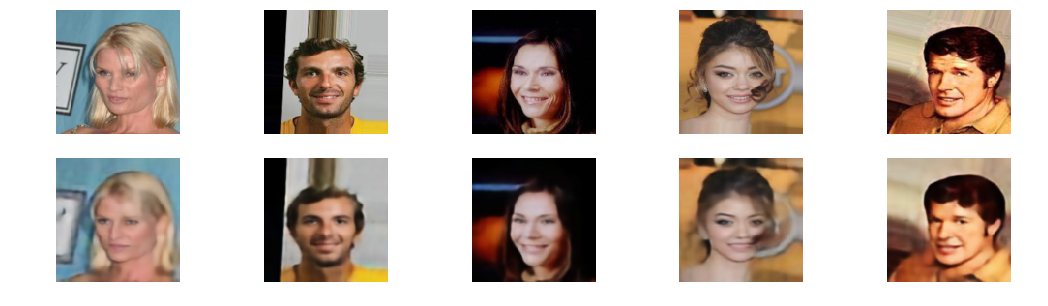

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch.autograd import Variable


model = AutoEncoder(in_channels=3, dec_channels=32, latent_size=1000)
model.load_state_dict(torch.load('autoencoder_i_20_cpu.pt'))
model.eval()
torch.manual_seed(random_seed)

for batch_idx, features in enumerate(train_loader):
    features = Variable(features)
    logits, decoded = model(features)
    break



##########################
### VISUALIZATION
##########################

n_images = 5

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(18, 5))
orig_images = features.data.numpy()[:n_images]
orig_images = np.moveaxis(orig_images, 1, -1)

decoded_images = decoded.data.numpy()[:n_images]
decoded_images = np.moveaxis(decoded_images, 1, -1)


for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].axis('off')
        ax[i].imshow(img[i])